In [30]:
import ultralytics
import os
import shutil
import xml.etree.ElementTree as ET
import cv2
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from ultralytics import YOLO

In [5]:
def extract_data_from_xml(path):
    tree = ET.parse(path)
    root = tree.getroot()

    image_paths = []
    image_sizes = []
    image_labels = []
    bounding_boxes = []

    for image in root:
        bbs_of_image = []
        labels_of_image = []

        for bbs in image.findall('taggedRectangles'):
            for bb in bbs:
                if not bb[0].text.isalnum():
                    continue
                if 'é' in bb[0].text.lower() or 'ñ' in bb[0].text.lower():
                    continue

                bbs_of_image.append(
                    [
                        float(bb.attrib['x']),
                        float(bb.attrib['y']),
                        float(bb.attrib['width']),
                        float(bb.attrib['height']),
                    ]
                )
                labels_of_image.append(bb[0].text.lower())

        #store
        image_paths.append(image[0].text)
        image_sizes.append((int(image[1].attrib['x']), int(image[1].attrib['y'])))
        bounding_boxes.append(bbs_of_image)
        image_labels.append(labels_of_image)

    return image_paths, image_sizes, image_labels, bounding_boxes

In [6]:
dataset_dir = 'datasets/SceneTrialTrain'
words_xml_path = os.path.join(dataset_dir, 'words.xml')
image_paths, image_sizes, image_labels, bounding_boxes = extract_data_from_xml(words_xml_path)

In [7]:
print(f"Number of images: {len(image_paths)}")
print(f"Example image path: {image_paths[0]}")
print(f"Example image size: {image_sizes[0]}")
print(f"Example bounding boxes: {bounding_boxes[0][:2]}")
print(f"Example labels: {image_labels[0][:2]}")

Number of images: 250
Example image path: apanar_06.08.2002/IMG_1261.JPG
Example image size: (1600, 1200)
Example bounding boxes: [[174.0, 392.0, 274.0, 195.0], [512.0, 391.0, 679.0, 183.0]]
Example labels: ['self', 'adhesive']


In [8]:
def convert_to_yolo_format(image_paths, image_sizes, bounding_boxes):
    yolo_data = []

    for image_path, image_size, bboxes in zip(image_paths, image_sizes, bounding_boxes):
        image_width, image_height = image_size

        yolo_labels = []

        for bbox in bboxes:
            x, y, w, h = bbox
            center_x = (x + w / 2) / image_width
            center_y = (y + h / 2) / image_height
            normalized_width = w / image_width
            normalized_height = h / image_height

            class_id = 0

            yolo_label = f"{class_id} {center_x} {center_y} {normalized_width} {normalized_height}"
            yolo_labels.append(yolo_label)

        yolo_data.append((image_path, yolo_labels))

    return yolo_data

In [9]:
class_labels = ['text']
yolo_data = convert_to_yolo_format(image_paths,image_sizes,bounding_boxes)

### Split data


In [10]:
seed = 0
val_size = 0.2
test_size = 0.125
is_shuffle = True
train_data, test_data = train_test_split(
    yolo_data,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle,
)
test_data, val_data = train_test_split(
    test_data,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle,
)

### Save data


In [11]:
def save_data(data, src_img_dir, save_dir):
    os.makedirs(save_dir, exist_ok=True)

    os.makedirs(os.path.join(save_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(save_dir, 'labels'), exist_ok=True)

    for image_path, yolo_labels in data:
        shutil.copy(os.path.join(src_img_dir, image_path), os.path.join(save_dir, 'images'))

        image_name = os.path.basename(image_path)
        image_name = os.path.splitext(image_name)[0]

        with open(os.path.join(save_dir, 'labels', f'{image_name}.txt'),'w') as f:
            for label in yolo_labels:
                f.write(f'{label}\n')

In [12]:
save_yolo_data_dir = "datasets/yolo_data"
os.makedirs(save_yolo_data_dir, exist_ok=True)
save_train_dir = os.path.join(save_yolo_data_dir, "train")
save_val_dir = os.path.join(save_yolo_data_dir, "val")
save_test_dir = os.path.join(save_yolo_data_dir, "test")

save_data(train_data, dataset_dir, save_train_dir)
save_data(test_data, dataset_dir, save_val_dir)
save_data(val_data, dataset_dir, save_test_dir)

### Training

In [19]:
model = YOLO('yolo11m.pt')
model.to('cuda')
results = model.train(
    data="data'.yaml",
    epochs=100,
    imgsz=640,
    cache=True,
    patience=20,
    plots=True,
)

engine/trainer: task=detect, mode=train, model=yolo11m.pt, data=data'.yaml, epochs=100, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=True, device=cuda:0, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=False, optimize=False, int8=False, dynamic=Fal

100%|██████████| 755k/755k [00:00<00:00, 19.5MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    111872  ultralytics.nn.modules.block.C3k2            [128, 256, 1, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  1    444928  ultralytics.nn.modules.block.C3k2            [256, 512, 1, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  7                  -1  1   2360320  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 97.9MB/s]


AMP: checks passed ✅


train: Scanning /content/datasets/yolo_data/train/labels... 200 images, 7 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<00:00, 1517.07it/s]

train: New cache created: /content/datasets/yolo_data/train/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.2GB RAM): 100%|██████████| 200/200 [00:01<00:00, 177.43it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/datasets/yolo_data/val/labels... 43 images, 2 backgrounds, 0 corrupt: 100%|██████████| 43/43 [00:00<00:00, 1291.16it/s]

val: New cache created: /content/datasets/yolo_data/val/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.0GB RAM): 100%|██████████| 43/43 [00:00<00:00, 93.00it/s]


Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train5
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      8.78G      1.977      2.913      1.754         28        640: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.19s/it]

                   all         43        200      0.546      0.485      0.469      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100       8.8G      1.204      1.365       1.14         81        640: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]

                   all         43        200      0.681      0.673      0.704      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      8.81G      1.183      1.222       1.17         30        640: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.55it/s]

                   all         43        200      0.172      0.265     0.0962     0.0385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      8.72G      1.333      1.288       1.27         37        640: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.36it/s]

                   all         43        200    0.00383      0.035   0.000655   0.000134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100       8.9G      1.384      1.377      1.323         34        640: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.77it/s]

                   all         43        200    0.00383      0.035   0.000655   0.000134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100       8.9G      1.403      1.298      1.256         47        640: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.72it/s]

                   all         43        200     0.0011      0.035   0.000552    0.00014



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      8.75G      1.338      1.258      1.254         34        640: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.75it/s]

                   all         43        200    0.00734       0.05    0.00397    0.00103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      8.86G       1.38      1.258      1.232         79        640: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.87it/s]

                   all         43        200     0.0143       0.08    0.00667    0.00275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      8.86G      1.308      1.296      1.225         53        640: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]

                   all         43        200    0.00046      0.015     0.0002    7.3e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      8.93G      1.302      1.171      1.236         51        640: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]

                   all         43        200     0.0185      0.365     0.0111    0.00499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      8.92G      1.302      1.162       1.23         29        640: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.34it/s]


                   all         43        200     0.0283       0.62     0.0245     0.0132

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      8.88G      1.295       1.12      1.202         61        640: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.34it/s]


                   all         43        200     0.0982      0.808     0.0914     0.0526

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      8.85G      1.269      1.049      1.186         43        640: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.46it/s]

                   all         43        200      0.253      0.715      0.231      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      8.85G      1.257      1.042      1.181         30        640: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]

                   all         43        200       0.59      0.775      0.659       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      8.86G      1.245      1.023      1.159         82        640: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.42it/s]

                   all         43        200      0.593      0.671      0.596      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100       8.9G      1.189     0.9724      1.159         45        640: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.48it/s]

                   all         43        200      0.501      0.675      0.529      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      8.83G      1.146      0.933      1.124         59        640: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.48it/s]

                   all         43        200      0.711      0.715        0.7      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      8.79G      1.121     0.9311      1.121         62        640: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]

                   all         43        200      0.637       0.71      0.717      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      8.92G      1.112     0.9239      1.106         54        640: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]

                   all         43        200      0.698      0.665      0.685      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100       8.9G      1.122     0.9229      1.112         76        640: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.46it/s]

                   all         43        200      0.731      0.765      0.747      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      8.88G      1.042     0.8706       1.08         74        640: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.52it/s]

                   all         43        200      0.755      0.755      0.774      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      8.91G      1.157     0.9673      1.125         93        640: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.60it/s]

                   all         43        200      0.667      0.771      0.714      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      8.91G      1.077     0.8392      1.062         51        640: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.52it/s]

                   all         43        200      0.775       0.78      0.818      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      8.88G      1.119     0.8785      1.088         52        640: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.47it/s]

                   all         43        200       0.81       0.79      0.794      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      8.76G      1.031     0.8385       1.06         65        640: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.48it/s]

                   all         43        200      0.787      0.829      0.842      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      8.93G       1.07     0.8272      1.077         49        640: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]

                   all         43        200      0.783      0.812      0.822      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      8.85G      1.008      0.832      1.092         30        640: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.52it/s]

                   all         43        200      0.852      0.845      0.864      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100       8.9G      1.004     0.7885      1.056         41        640: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.55it/s]

                   all         43        200      0.875      0.804      0.867      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      8.86G      1.002     0.8193      1.077         58        640: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.42it/s]


                   all         43        200      0.799      0.872      0.836      0.558

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      8.89G     0.9789     0.7688       1.05         34        640: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.01it/s]

                   all         43        200      0.808       0.85      0.848      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      8.94G      1.013     0.8072      1.069         30        640: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]

                   all         43        200        0.9        0.8      0.865      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      8.93G     0.9977     0.7682      1.046         67        640: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.50it/s]

                   all         43        200      0.852       0.88       0.86      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      8.81G     0.9806     0.7179      1.035         63        640: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.53it/s]

                   all         43        200      0.851       0.86      0.859      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      8.91G       1.01     0.7906      1.071         87        640: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.98it/s]

                   all         43        200      0.899       0.81      0.881      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100       8.9G     0.9427      0.746      1.038         42        640: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.48it/s]

                   all         43        200      0.825      0.855      0.862        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100       8.9G     0.9657     0.7293      1.033         35        640: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.50it/s]

                   all         43        200      0.863      0.765      0.856      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      8.71G     0.9556     0.7299      1.046         31        640: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.49it/s]

                   all         43        200      0.741      0.873      0.818      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      8.85G     0.9639     0.7247      1.038         54        640: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]


                   all         43        200      0.833       0.83      0.878      0.629

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100       8.9G     0.9018     0.7133      1.017         37        640: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.54it/s]

                   all         43        200      0.774       0.91      0.865      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      8.92G      0.905     0.7093      1.026         73        640: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.49it/s]

                   all         43        200      0.826      0.853      0.886      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      8.88G     0.8968     0.6774      1.015         46        640: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.54it/s]

                   all         43        200      0.831       0.85      0.876      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      8.91G     0.9288     0.6991       1.02         66        640: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]

                   all         43        200      0.839      0.885      0.871      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100       8.9G     0.9066     0.6758      1.019         43        640: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.52it/s]

                   all         43        200      0.795      0.911      0.885      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100       8.9G     0.9148     0.6776      1.026         46        640: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.55it/s]

                   all         43        200      0.867      0.813      0.865      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      8.72G     0.8825     0.6561     0.9883         41        640: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.51it/s]

                   all         43        200      0.878      0.825      0.892      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      8.86G     0.8846     0.7001      1.012         44        640: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.14it/s]

                   all         43        200      0.892      0.826      0.884      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      8.89G      0.864     0.6493      1.007         36        640: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.43it/s]

                   all         43        200      0.887       0.81      0.876      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      8.94G     0.8439      0.628      0.997        102        640: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.51it/s]

                   all         43        200      0.858      0.873      0.892       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      8.88G     0.8421     0.6243     0.9903         48        640: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.54it/s]

                   all         43        200      0.857      0.871      0.895       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      8.86G     0.8913     0.6305     0.9917         70        640: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]

                   all         43        200      0.869       0.88      0.895      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      8.85G     0.8257     0.6122     0.9795         33        640: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.54it/s]

                   all         43        200       0.79      0.923      0.898       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      8.77G     0.8361     0.5987     0.9951         51        640: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.48it/s]

                   all         43        200      0.872      0.855      0.887      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      8.85G     0.8041     0.5649     0.9803         61        640: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.46it/s]

                   all         43        200      0.858      0.849      0.864      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      8.89G     0.8092     0.5655     0.9812         51        640: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.99it/s]

                   all         43        200      0.874       0.85      0.893      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      8.88G     0.8023     0.5941     0.9745         37        640: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]

                   all         43        200      0.816       0.91      0.889      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      8.93G     0.8035     0.5926      0.972         31        640: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]


                   all         43        200      0.876       0.86      0.899      0.665

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      8.85G     0.8442     0.5891      0.982         61        640: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.44it/s]

                   all         43        200      0.893      0.895      0.924      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      8.85G     0.8069     0.5879     0.9868         62        640: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.07it/s]


                   all         43        200      0.912      0.895      0.913      0.675

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      8.88G     0.7548     0.5634     0.9405         43        640: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.41it/s]

                   all         43        200       0.88       0.89      0.917      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      8.85G     0.7698     0.5362      0.964         47        640: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.57it/s]

                   all         43        200      0.874      0.866      0.895      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      8.84G     0.7521     0.5434     0.9645         63        640: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.54it/s]

                   all         43        200      0.866       0.86      0.902      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      8.86G     0.7924     0.5701     0.9836         33        640: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]

                   all         43        200      0.861      0.865      0.882      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      8.86G     0.7554      0.548     0.9572         64        640: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.42it/s]

                   all         43        200      0.838      0.904      0.889      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      8.79G     0.7505     0.5435     0.9529         64        640: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.46it/s]

                   all         43        200      0.851      0.911      0.898      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      8.88G     0.7599     0.5487     0.9486         41        640: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

                   all         43        200      0.846      0.907      0.898      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      8.83G     0.7616     0.5239     0.9618         80        640: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.99it/s]

                   all         43        200      0.851      0.884      0.904       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      8.85G     0.7488     0.5259     0.9535         50        640: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.53it/s]

                   all         43        200      0.859      0.845      0.898      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      8.78G     0.7664     0.5397     0.9653         75        640: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.61it/s]

                   all         43        200      0.861      0.866      0.891      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      8.76G     0.7138     0.5066     0.9402         42        640: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.53it/s]

                   all         43        200      0.835       0.91      0.894      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      8.88G     0.7348     0.5242     0.9444         42        640: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.70it/s]

                   all         43        200      0.871      0.865      0.896      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100       8.9G     0.7452     0.5229     0.9623         34        640: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.55it/s]

                   all         43        200      0.881       0.87      0.911      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      8.91G     0.7566     0.5419     0.9694         51        640: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]

                   all         43        200      0.877       0.92      0.919      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      8.79G     0.7277     0.5339     0.9509         69        640: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.53it/s]

                   all         43        200      0.885      0.882      0.911      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      8.77G     0.7462     0.5305     0.9759         33        640: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.27it/s]

                   all         43        200      0.877       0.87      0.891      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      8.85G     0.7003     0.4966     0.9481         53        640: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.49it/s]

                   all         43        200      0.846        0.9      0.897      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      8.85G     0.7059     0.4949     0.9379         50        640: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.58it/s]

                   all         43        200      0.938      0.839       0.92      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      8.86G      0.673      0.484     0.9268         61        640: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.48it/s]

                   all         43        200      0.921       0.86      0.924      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      8.83G     0.6923     0.4739     0.9341         53        640: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.31it/s]

                   all         43        200      0.851        0.9      0.908      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      8.78G     0.6901     0.4685     0.9186         54        640: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.54it/s]

                   all         43        200      0.882      0.896      0.918      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100       8.9G     0.6489     0.4618     0.9263         54        640: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.59it/s]

                   all         43        200      0.898      0.883      0.916      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      8.79G     0.6461     0.4695     0.9308         45        640: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.53it/s]

                   all         43        200      0.848      0.918      0.911      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      8.86G      0.688     0.4702      0.928         94        640: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.01it/s]

                   all         43        200      0.851      0.915      0.919      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      8.89G     0.6617     0.4605     0.9285         67        640: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]

                   all         43        200      0.877       0.87      0.914      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      8.89G     0.6625     0.4618     0.9257         58        640: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.53it/s]

                   all         43        200      0.893      0.835      0.906      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      8.88G     0.6498     0.4554     0.9342         72        640: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.56it/s]

                   all         43        200      0.932      0.835      0.914      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      8.88G     0.6386      0.441     0.9223         61        640: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.57it/s]

                   all         43        200      0.914       0.86      0.916      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      8.88G     0.6515     0.4627     0.9302         45        640: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.49it/s]

                   all         43        200      0.908      0.855      0.919      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      8.88G     0.6243     0.4528     0.9209         72        640: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.55it/s]

                   all         43        200      0.905      0.885      0.931       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      8.73G     0.6186     0.4288     0.9017         51        640: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.54it/s]

                   all         43        200      0.885       0.91      0.929      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100       8.9G     0.5984     0.4152     0.8969         70        640: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.48it/s]

                   all         43        200      0.885      0.922      0.932      0.725


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      8.88G     0.6969     0.5044     0.9236         47        640: 100%|██████████| 13/13 [00:08<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]

                   all         43        200      0.905        0.9      0.932      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      8.86G     0.7022     0.5057     0.9279         50        640: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.49it/s]

                   all         43        200      0.881      0.922      0.935      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      8.78G     0.6848     0.4865     0.9183         19        640: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.55it/s]

                   all         43        200      0.908      0.885       0.93      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      8.87G      0.661     0.4669     0.9205         54        640: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.56it/s]

                   all         43        200      0.913      0.895      0.931      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      8.93G     0.6749     0.4739     0.9227         26        640: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]

                   all         43        200       0.89      0.888      0.925      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      8.92G     0.6576     0.4624     0.9186         22        640: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.55it/s]

                   all         43        200      0.922       0.88       0.93      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      8.83G     0.6444     0.4444     0.9018         33        640: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.48it/s]

                   all         43        200      0.892      0.907      0.929      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      8.95G     0.6377     0.4422     0.9073         33        640: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.51it/s]

                   all         43        200      0.895      0.905      0.921      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      8.88G     0.6284     0.4452     0.9004         18        640: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.14it/s]

                   all         43        200      0.892       0.91      0.922      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      8.95G      0.626     0.4357     0.8914         36        640: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.56it/s]

                   all         43        200      0.916       0.88      0.923      0.725



100 epochs completed in 0.266 hours.
Optimizer stripped from runs/detect/train5/weights/last.pt, 40.5MB
Optimizer stripped from runs/detect/train5/weights/best.pt, 40.5MB

Validating runs/detect/train5/weights/best.pt...
Ultralytics 8.3.74 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 303 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.61it/s]


                   all         43        200      0.913      0.895       0.93      0.733
Speed: 0.3ms preprocess, 10.6ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/train5


### Evaluation

In [22]:
model_path = "runs/detect/train5/weights/best.pt"
model = YOLO(model_path)

metrics = model.val()

Ultralytics 8.3.74 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 303 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


val: Scanning /content/datasets/yolo_data/val/labels.cache... 43 images, 2 backgrounds, 0 corrupt: 100%|██████████| 43/43 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.64it/s]


                   all         43        200      0.913      0.895       0.93      0.731
Speed: 4.2ms preprocess, 22.4ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/val


### Inference

In [26]:
def visualize_bbox(
    img_path, predictions, conf_thres=0.8, font=cv2.FONT_HERSHEY_SIMPLEX
):
    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    for prediction in predictions:
        conf_score = prediction["confidence"]

        if conf_score < conf_thres:
            continue

        bbox = prediction["box"]
        xmin = int(bbox["x1"])
        ymin = int(bbox["y1"])
        xmax = int(bbox["x2"])
        ymax = int(bbox["y2"])

        cv2.rectangle(img, (xmin,ymin), (xmax,ymax), (0,255,0), 3)

        text = f"{conf_score:.2f}"
        (text_width, text_height), _ = cv2.getTextSize(text,font,1,2)

        cv2.rectangle(
            img,
            (xmin,ymin - text_height - 5),
            (xmin + text_width, ymin),
            (0,255,0),
            -1,
        )
        cv2.putText(img,text,(xmin,ymin-5),font,1,(0,0,0),2)

    return img


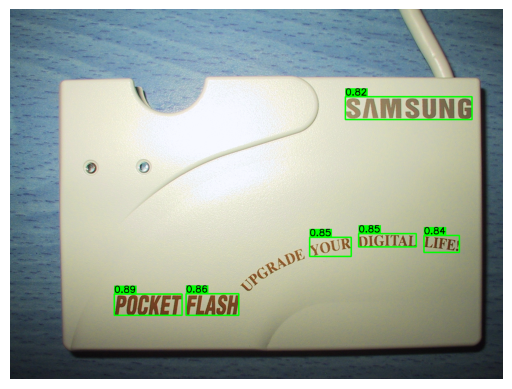

In [31]:
model_path = "runs/detect/train5/weights/best.pt"
img_path = "datasets/SceneTrialTrain/apanar_06.08.2002/IMG_1255.JPG"
conf_thres = 0.75
model = YOLO(model_path)

results = model(img_path,verbose= False)
predictions = json.loads(results[0].to_json())
visualized_img = visualize_bbox(img_path,predictions,conf_thres)

%matplotlib inline
plt.imshow(visualized_img)
plt.axis("off")
plt.show()